In [1]:
import pandas as pd
import os
import sys
import zipfile
import json
from tqdm.auto import tqdm
tqdm.pandas()
from ipywidgets import interact
import re
import pickle
util_dir = os.path.abspath('../utils')
sys.path.append(util_dir)
from utils import *

C:\Users\veldhuis\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Read the table with P numbers of tablets that belong to the Treasure Archive and Shoe Archive. Retrieve a list of numbers.

In [2]:
file = 'csv/treasury_shoes2.txt'
tr_df = pd.read_csv(file, encoding='utf8')
ids = list(tr_df['id_text'])
ids.sort()

If necessary, download the Ur3 JSON from epsd2. If the file is already in the directory `/jsonzip`, skip this step, but do assign 'epsd2/admin/ur3' to the variable `project`.

In [3]:
project = 'epsd2/admin/ur3'
#oracc_download([project]);

Function for parsing the JSON. Words that appear in year names are marked in the field `ftype`.

In [4]:
def parsejson(text):
    for JSONobject in text["cdl"]:
        if "cdl" in JSONobject: 
            parsejson(JSONobject)
        if "label" in JSONobject:
            meta_d["label"] = JSONobject['label']
        if "f" in JSONobject:
            lemma = JSONobject["f"]
            if "ftype" in JSONobject:
                lemma['ftype'] = JSONobject['ftype'] # this picks up YN for year name
            lemma["id_word"] = JSONobject["ref"]
            lemma['label'] = meta_d["label"]
            lemma["id_text"] = meta_d["id_text"]
            lemm_l.append(lemma)
        if "strict" in JSONobject and JSONobject["strict"] == "1":
            lemma = {key: JSONobject[key] for key in dollar_keys}
            lemma["id_word"] = JSONobject["ref"]
            lemma["id_text"] = meta_d["id_text"]
            lemm_l.append(lemma)
    return

Call the parser for each of the P numbers in the list `ids`. The parser function needs the lists `lemm_l` and `dollar_keys`, as well as the dictionary `meta_d`. These objects are manipulated during the parsing process.

In [5]:
lemm_l = []
meta_d = {"label": None, "id_text": None}
dollar_keys = ["extent", "scope", "state"]
file = f"jsonzip/{project.replace('/', '-')}.zip"
try:
    z = zipfile.ZipFile(file) 
except:
    print(f"{file} does not exist or is not a proper ZIP file")
files = z.namelist() # list of all the files in the ZIP file
files = [name for name in files if name[-12:-5] in ids] # select only those of the treasury/leather archive
for filename in tqdm(files, desc = project):
    id_text = project + filename[-13:-5] 
    meta_d["id_text"] = id_text
    try:
        st = z.read(filename).decode('utf-8')
        data_json = json.loads(st)           
        parsejson(data_json)
    except:
        print(f'{id_text} is not available or not complete')
z.close()

epsd2/admin/ur3/P143238 is not available or not complete



The function `parsejson()` fills the lists `lemm_l` with data. Read this list into a DataFrame.

In [6]:
words = pd.DataFrame(lemm_l).fillna('')
keep = ['extent', 'scope', 'state', 'id_word', 'id_text', 'form', 'cf', 'gw', 'pos', 'ftype', 'label']
words = words[keep]

Remove comma's and spaces from Guide words

In [7]:
words['gw'] = words['gw'].replace([' ', ','], ['', ''], regex=True)

Simplify `id_text` ('P123456' instead of 'epsd2/admin/ur3/P123456') and add a field `id_line`.

In [8]:
words['id_text'] = [i[-7:] for i in words['id_text']]
words['id_line'] = [int(i.split('.')[1]) for i in words['id_word']]

In [9]:
proper_nouns = ['RN', 'PN', 'DN', 'AN', 'WN', 'ON', 'TN', 'CN', 'GN', 'SN']
physical_break = ['illegible', 'traces', 'missing', 'effaced']
logical_break = ['other', 'blank', 'ruling']
words['lemma'] = words["cf"] + '[' + words["gw"] + ']' + words["pos"]
words.loc[words["cf"] == "" , 'lemma'] = words['form'] + '[NA]NA'
words.loc[words["pos"] == "n" , 'lemma'] = words['form'] + '[]NU'
words.loc[words["state"].isin(logical_break), 'lemma'] = "break_logical"
words.loc[words["state"].isin(physical_break), 'lemma'] = "break_physical"
words.head(10)

,extent,scope,state,id_word,id_text,form,cf,gw,pos,ftype,label,id_line,lemma
0,n,line,missing,P104232.3,P104232,,,,,,,3,break_physical
1,,,,P104232.5.1,P104232,šu,šu,hand,N,,r 1,5,šu[hand]N
2,,,,P104232.5.2,P104232,ba-ti,teŋ,near,V/i,,r 1,5,teŋ[near]V/i
3,,,,P104232.6.1,P104232,ša₃,šag,heart,N,,r 2,6,šag[heart]N
4,,,,P104232.6.2,P104232,puzur₄-iš-{d}da-gan,Puzrišdagan,1,SN,,r 2,6,Puzrišdagan[1]SN
5,,,,P104232.7.1,P104232,iti,itud,moon,N,,r 3,7,itud[moon]N
6,,,,P104232.7.2,P104232,ki-siki-{d}nin-a-zu,Kisikininazuk,1,MN,,r 3,7,Kisikininazuk[1]MN
7,,,,P104232.7.3,P104232,min-kam,min,two,NU,,r 3,7,min[two]NU
8,,,,P104232.8.1,P104232,mu,mu,year,N,yn,r 4,8,mu[year]N
9,,,,P104232.8.2,P104232,si-mu-ru-um{ki},Si.mu.ru.um,00,SN,yn,r 4,8,Si.mu.ru.um[00]SN


Read list of name forms and Normalized names

In [10]:
normdf = pd.read_csv('Normalized/drehem_norm_names.csv', encoding='utf8')
normdf

,transliteration,normalization,remarks
0,A-AN-ba-az,A.AN.ba.az[]PN,MVN 13 464 r 10 (copy/photo)
1,A-KU-um,A.KU.um[]PN,"Aegyptus 10, 270 27 o 7 (copy)"
2,A-KU.KU-ta,A.KU.KU[]PN,AnOr 12 277 o i 17' (copy)
3,A-NI-ta,A.NI[]PN,Babyl. 7 pl. 22 18 o 3 (copy)
4,A-U.E₂-nu-tuku,A.U.E₂.nu.tuku[]PN,AnOr 07 150 o 2: A-U.KID-nu-tuku IŠ (copy/photo)
...,...,...,...
5802,{d}utu,Utu[]DN,NaN
5803,{d}utu-bar-ra,Utubara[]DN,NaN
5804,Ma₂-gur₈-mah,Magurmah[]ON,NaN
5805,Ma₂-dara₃-abzu,Madaraʾabzu[]ON,NaN


Download OGSL

In [11]:
oracc_download(['ogsl']);

Saving http://build-oracc.museum.upenn.edu/json/ogsl.zip as jsonzip/ogsl.zip.


List Ur 3 sign equivalencies

In [12]:
equiv = {'ANŠE' : 'GIR₃', 
        'DUR₂' : 'KU', 
        'NAM₂' : 'TUG₂', 
        'TIL' : 'BAD', 
        'NI₂' : 'IM',
        'ŠAR₂' : 'HI', 
        }
w = re.compile(r'\w+') # replace whole words only - do not replace TILLA with BADLA.
           # but do replace |SAL.ANŠE| with |SAL.GIR₃|

Parse OGSL

In [13]:
def parseogsljson(data_json):
    for key, value in data_json["signs"].items():
        key = re.sub(w, lambda m: equiv.get(m.group(), m.group()), key)
        if "values" in value:
            for n in value["values"]:
                d2[n] = key
    return

Create OGSL dictionary key = sign value, value = sign name.

In [14]:
d2 = {}  # this empty dictionary is filled by the parsejson() function, called in this cell.
file = "jsonzip/ogsl.zip"
z = zipfile.ZipFile(file) 
filename = "ogsl/ogsl-sl.json"
signlist = z.read(filename).decode('utf-8')
data_json = json.loads(signlist)                # make it into a json object (essentially a dictionary)
parseogsljson(data_json)  
with open('output/ogsl_dict.p', 'wb') as p:
    pickle.dump(d2, p)  

In [15]:
separators = ['{', '}', '-']
separators2 = ['.', '+', '|']  # used in compound signs
#operators = ['&', '%', '@', '×']
flags = "][?<>⸢⸣⌈⌉*/" # note that ! is omitted from flags, because it is dealt with separately
table = str.maketrans(dict.fromkeys(flags))

In [16]:
def signnames(translit):  
    """This function takes a string of transliterated cuneiform text and translates that string into a string of
    sign names, separated by spaces. In order to work it needs the variables separators, separators2, and table defined above. The variable table
    is used by the translate() method to translate all flags (except for !) to None. The function also needs a dictionary, called d2, that has as
    keys sign readings and sign names as corresponding values. In case a key is not found, the sign reading is replaced by itself."""
    signnames_l = []
    translit = translit.translate(table).lower()  # remove flags, half brackets, square brackets.
    translit = translit.replace('...', 'x')
    for s in separators: # split transliteration line into signs   
        translit = translit.replace(s, ' ').strip()
    s_l = translit.split() # s_l is a list that contains the sequence of transliterated signs without separators or flags
    s_l = [d2.get(sign, sign) for sign in s_l] # replace each transliterated sign with its sign name.
    # Now take care of some special situations: signs with qualifiers, compound signs.
    for sign in s_l:
        if '!' in sign: # corrected sign, as in ka!(SAG), get only the corrected reading.
            sign = sign.split('!(')[0]
            sign = sign.replace('!', '') # remove remaining exclamation marks
        elif sign[-1] == ')' and '(' in sign: # qualified sign, as in ziₓ(SIG₇) - get only the qualifier
            sign = sign.split('(')[1][:-1]
        if '×' in sign: #compound. Compound like |KA×NINDA| to be replaced by |KA×GAR|
            sign_l = sign.replace('|', '').split('×')
            #replace individual signs of the compound by OGSL names
            sign_l = [d2.get(sign, sign) for sign in sign_l] 
            # if user enters |KA*EŠ| this is transformed to ['KA', '|U.U.U|']. The pipes around U.U.U must be replaced by brackets
            sign_l = [f'({sign[1:-1]})' if len(sign) > 1 and sign[0] == '|' else sign for sign in sign_l]
            sign = f"|{'×'.join(sign_l)}|"  #put the sign together again with enclosing pipes.
        elif '.' in sign or '+' in sign: # using elif, so that compounds like |UD×(U.U.U)| are not further analyzed.
            for s in separators2:
                sign = sign.replace(s, ' ').strip() 
            sign_l = sign.split()  # compound sign split into multiple signs
            sign_l = [d2.get(sign, sign) for sign in sign_l]
            for se in separators2:   # in case d2.get returns a compound sign name
                sign_l = [si.replace(se, ' ').strip() for si in sign_l]
            signnames_l.extend(sign_l)
            continue
        sign = d2.get(sign, sign)
        signnames_l.append(sign)
    # add space before and after each line so that each sign representation is enclosed in spaces
    signnames = f" {' '.join(signnames_l).upper()} " 
    return signnames

Make a new field in the Normalized Names table, representing the sign sequence (sign names) of the transliteration of each name.

In [17]:
normdf["sign_names"] = normdf["transliteration"].progress_map(signnames)

Create a dictionary with `sign_names` as key and `normalization` as value.

In [18]:
normd2 = dict(zip(normdf['sign_names'], normdf['normalization']))

Add a column to `words` with the sequence of sign names for each word.

In [19]:
words['sign_names'] = words['form'].progress_map(signnames)

Use the `normd2` dictionary to transform sign name sequences into normalized names.

In [20]:
#words.loc[(words.pos.isin(proper_nouns + ['X'])) & (words.lemma.str.contains('.')), 
#          'lemma'] = words.progress_apply(lambda x: normd2.get(x['sign_names'], x['lemma']), axis=1)
words.loc[words.pos.isin(proper_nouns + ['X']), 'lemma'] = words.progress_apply(lambda x: normd2.get(x['sign_names'], x['lemma']), axis=1)

Use the (temporary) corrections.csv file to apply corrections to the lemmatization

In [21]:
corrections = pd.read_csv('Normalized/corrections.csv', encoding='utf8')
corr_d = dict(zip(corrections['form'], corrections['corr']))
words.loc[words.pos.isin(['PN', 'RN', 'X', 'DN']), 'lemma'] = words.progress_apply(lambda x: corr_d.get(x['form'], x['lemma']), axis =1)
words['pos'] = [w.split(']')[-1] if ']' in w else '' for w in words['lemma']]

In [22]:
texttype = []
for i in ids:
    ttype = ''
    text = list(words.loc[words.id_text == i, 'lemma'])
    if 'mu.DU[delivery]N' in text:
        ttype = 'intake'
    elif 'zig[rise]V/i' in text:
        ttype = 'expenditure'
    elif 'teŋ[near]V/i' in text: 
        ttype = 'transfer'
    texttype.append(ttype)
treasure = dict(zip(ids, texttype))

Select PNs (and RNs) but skip those that appear in Year Names or Seals. Add lugal (king) sukkalmah (prime minister) and nin (queen).

In [23]:
unnamed = {'lugal[king]N', 'nin[queen]N', 'sukkalmah[official]N'}
names = set(words.loc[words.pos.isin(['PN', 'RN', 'DN']), 'lemma'])
actors = unnamed | names
seal = list(words.loc[words.label.str.contains('seal'), 'id_word'])
yn = list(words.loc[words.ftype == 'yn', 'id_word'])
exclude = seal + yn
PNs = words.loc[(words.lemma.isin(actors)) & (~words.id_word.isin(exclude))].copy()

# Define keywords and the corresponding roles

In [24]:
key_post = {'mu.DU[delivery]N': 'deliverer', 'maškim[administrator]N' : 'representative', 
               'zig[rise]V/i' : 'expender',
               'šu[hand]N teŋ[near]V/i': 'recipient' , 'šu[hand]N us[follow]V/t': 'sender'}
key_pre =  {'ŋiri[foot]N' : 'intermediary', 
            'arua[offering]N' : 'offerer', 'kišib[seal]N' : 'sealer', 
            'gabari[copy]N kišib[seal]N' : 'sealer', 'mu.DU[delivery]N' : 'deliverer',
            'mu[name]N' : 'reason', 'ki[place]N' : 'source', 'kiŋ[work]N ak[do]N' : 'producer'}

# Determine the Role of each PN
TODO: default role in texttype transfer. Check default roles for other text types.

In [25]:
role = []
attribute = []
for i in PNs.index:                           # the index of PNs is identical to the one of words
    Pno = PNs.loc[i]['id_text']                    # the text ID (P number)
    lineno = PNs.loc[i]['id_line']                 # the line number inwhich the PN appears
    text = words.loc[words.id_text == Pno]                # the entire text
    line = text.loc[text.id_line == lineno] #  the line with the PN
    mnw = line.index[0]                 # index no of firstword in line
    mxw = line.index[-1]                   # index no. of last word in line
    mx = text.index[-1]                    # index no. of last word in text
    mxl = text.loc[mx]['id_line']          # highest line number in text
    if lineno < mxl:                       # check that nextline is still in the same text
        nextlno = words.loc[mxw+1]['id_line']
        nextline = text.loc[text.id_line == nextlno] # words in nextline
    else:
        nextline = line
    attr = []
    r = ''
    if i < mxw:
        attr = list(line.loc[i+1:]['lemma'])
    if mnw == i:               # PN in first position
        r = key_post.get(line.loc[mxw]['lemma'], r)    # keyword appears in same line in last position
        r = key_post.get(words.loc[mxw+1]['lemma'], r) # or in the next line in first position
        if len(line) > 1:                   # additional words are attributes of the name
            lastwords = ' '.join(list(line[-2:]['lemma'])) # two-word keywords (as in šu ba-ti)
            r = key_post.get(lastwords, r)
        if len(nextline) > 1:               # two-word keyword appearing in first position in next line
            firstwords = ' '.join(list(nextline[:2]['lemma']))
            r = key_post.get(firstwords, r)
            
    elif i > mnw:             # PN appears further in line with keyword(s) preceding
        firstwords = ' '.join(list(line.loc[mnw:i-1]['lemma']))  # join all words before PN
        r = key_pre.get(firstwords, r)        # ŋiri₃ PN; ki PN-ta; kin ak PN; etc
        if line.loc[mnw]['lemma'] == 'ki[place]N' and line.loc[mxw]['form'].endswith('-še₃'): 
            r = 'destination'              # special case: ki PN-še₃         
        if r == '':                # role has not been filled yet
            PN = [w for w in line.loc[mnw:i-1]['lemma'] if w in list(PNs['lemma'])] # is there another PN previously in the line?
            if PN:
                if words.loc[i-1]['lemma'] == 'u[and]CNJ':
                    r = role[-1]               # same role as previous PN
                else:
                    r = 'relation'             # as in PN dumu PN
            elif treasure.get(Pno) == 'expenditure': # commodities + PN: recipient
                r = 'recipient'
            else:                              # if there is no preceding PN: drop the name
                r = 'none'                     # this may  need refinement
        if PNs.loc[i]['lemma'] in unnamed and words.loc[i-1]['lemma'] in list(PNs['lemma']):  
            r = 'none'       # 'unnamed' person is preceded byname
    if r == '' :
        if treasure.get(Pno) == 'expenditure': # default role for zi-ga/ba-zi texts
            r = 'recipient'
        elif treasure.get(Pno) == 'intake' or treasure.get(Pno) == 'transfer':    # default role for mu-DU texts
            r = 'source'
    role.append(r)
    attribute.append(' '.join(attr))
PNs['role'] = role
PNs['attribute'] = attribute

# Show results in a table with links for checking

In [26]:
anchor = '<a href="http://build-oracc.museum.upenn.edu/epsd2/admin/ur3/{}", target="_blank">{}</a>'
PNs2 = PNs.copy()
PNs2['id_word'] = [anchor.format(val,val) for val in PNs['id_word']]

In [27]:
@interact(rows = (1, len(PNs2), 1))
def showpns(rows = 25): 
    return PNs2.loc[PNs2.id_text == 'P103763', ['id_word', 'form', 'pos', 'lemma', 'role', 'attribute']][:rows].style

interactive(children=(IntSlider(value=25, description='rows', max=1064, min=1), Output()), _dom_classes=('widg…

# Create Edges
Needs checking. Deal with roles 'offerer' and 'reason'

In [28]:
intake = [i for i in ids if treasure.get(i) == 'intake']

In [29]:
edges = []
for i in ids:                              # one text ID at a time; muDU texts
    people = PNs.index[PNs.id_text == i]    # indexes of all the people in that text
    for p in people:                       # iterate over those indexes
        source = ''
        target = ''
        role = PNs.loc[p]['role']
        if role in ['intermediary', 'representative']:
            source = PNs.loc[p]['lemma']
            q = [n for n in people if n > p and PNs.loc[n]['role'] in ['recipient', 'sealer']]  # look for target after the source
            if q:
                target = PNs.loc[q[0]]['lemma']
        elif role in ['sender', 'deliverer', 'source']:
            source = PNs.loc[p]['lemma']
            q = [n for n in people if n > p and PNs.loc[n]['role'] in ['recipient', 'sealer', 'intermediary']] 
            if q:
                target = PNs.loc[q[0]]['lemma']
        elif role == 'relation':
            source = PNs.loc[p]['lemma']
            q = [n for n in people if n < p]
            if q:
                target = PNs.loc[q[-1]]['lemma']
        elif role in ['recipient', 'sealer']:
            target = PNs.loc[p]['lemma']
            q = [n for n in people if n > p and PNs.loc[n]['role'] in ['representative', 'source', 'intermediary']]
            if q:
                source = PNs.loc[q[0]]['lemma']
        if source and target:
            edges.append([source, target, i])

In [30]:
edgs = pd.DataFrame(edges)
edgs.columns = ['source', 'target', 'id_text']
anchor = '<a href="http://build-oracc.museum.upenn.edu/epsd2/admin/ur3/{}", target="_blank">{}</a>'
edgs2 = edgs.copy()
edgs2['id_text'] = [anchor.format(val,val) for val in edgs['id_text']]

In [31]:
@interact(rows = (1, len(edgs2), 1))
def showedges(rows = 25): 
    return edgs2.loc[edgs2.duplicated()][:rows].style

interactive(children=(IntSlider(value=25, description='rows', max=464, min=1), Output()), _dom_classes=('widge…

TODO: remove duplicates; make multiple edges between the same people into weights; make into directed graph

In [32]:
edgs = edgs.drop_duplicates()

In [33]:
edgs2 = edgs.groupby(['source', 'target']).agg({'id_text': list}).reset_index()

In [34]:
edgs2['weight'] = [len(i) for i in edgs2['id_text']]
edgs2

,source,target,id_text,weight
0,A.x[00]PN,Dayyanummišar[]PN,[P134047],1
1,Abba[]PN,Abba[]PN,[P200373],1
2,Abba[]PN,lugal[king]N,[P200373],1
3,Abisimti[]PN,Damu[]DN,[P144477],1
4,Abisimti[]PN,Gula[]DN,[P144477],1
...,...,...,...,...
402,ŠuʾEštar[]PN,Lugalkugzu[]PN,[P141790],1
403,ŠuʾEštar[]PN,Tahšatal[]PN,[P290169],1
404,ŠuʾEštar[]PN,X.x[00]PN,[P290169],1
405,ŠuʾEštar[]PN,Šulgiʾabi[]PN,[P127861],1


In [35]:
edgs2['id_text'] = [','.join(i)for i in edgs2['id_text']]

In [36]:
edgs2

,source,target,id_text,weight
0,A.x[00]PN,Dayyanummišar[]PN,P134047,1
1,Abba[]PN,Abba[]PN,P200373,1
2,Abba[]PN,lugal[king]N,P200373,1
3,Abisimti[]PN,Damu[]DN,P144477,1
4,Abisimti[]PN,Gula[]DN,P144477,1
...,...,...,...,...
402,ŠuʾEštar[]PN,Lugalkugzu[]PN,P141790,1
403,ŠuʾEštar[]PN,Tahšatal[]PN,P290169,1
404,ŠuʾEštar[]PN,X.x[00]PN,P290169,1
405,ŠuʾEštar[]PN,Šulgiʾabi[]PN,P127861,1


In [37]:
import networkx as nx
import matplotlib.pyplot as plt

In [38]:
G=nx.convert_matrix.from_pandas_edgelist(edgs2, 'source', 'target', ['id_text', 'weight'])

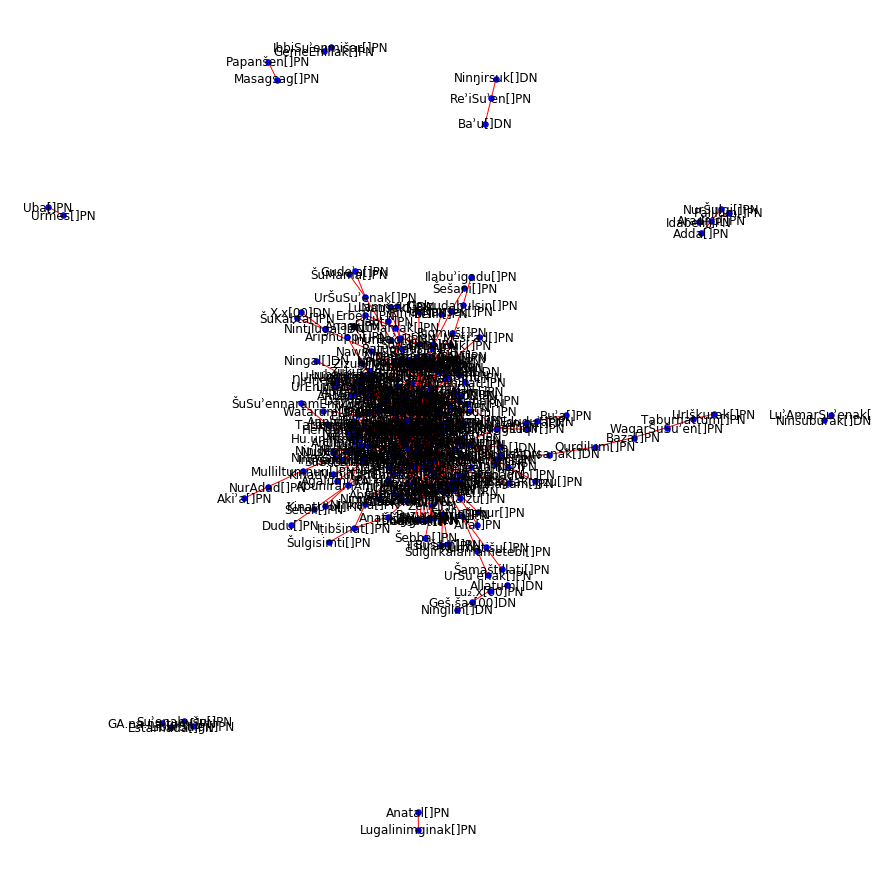

In [39]:
pos = nx.spring_layout(G)
plt.figure(3,figsize=(12,12)) 
nx.draw(G,pos, node_size=30, node_color = 'b', edge_color='r', with_labels=True)
plt.show()

In [40]:
node_attr = {name : name for name in G.nodes}
degree = {name : G.degree[name] for name in G.nodes}
node_size = {name : G.degree[name]*3 for name in G.nodes}
nx.set_node_attributes(G, node_attr, "name")
nx.set_node_attributes(G, degree, "degree")
nx.set_node_attributes(G, node_size, "node_size")

In [66]:
from bokeh.io import output_file, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx

# Prepare Data

# Show with Bokeh
plot = Plot(plot_width=1200, plot_height=900,
            x_range=Range1d(-2, 2), y_range=Range1d(-2, 2))
plot.title.text = "Drehem Treasure Archive"

graph_renderer = from_networkx(G, nx.circular_layout, scale=1.9, center=(0, 0))
graph_renderer.edge_renderer.data_source.data["line_width"] = [G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
graph_renderer.edge_renderer.glyph.line_width = {'field': 'line_width'}
graph_renderer.edge_renderer.glyph.line_alpha = 0.8
graph_renderer.node_renderer.selection_glyph = Circle(size='degree', fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size='degree', fill_color=Spectral4[1])
graph_renderer.node_renderer.glyph = Circle(size='degree', fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.inspection_policy = NodesAndLinkedEdges()
graph_renderer.selection_policy = EdgesAndLinkedNodes()

node_hover_tool = HoverTool(tooltips=[("name", "@name"), ('degree', '@degree')])
plot.renderers.append(graph_renderer)
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())
output_file("interactive_graphs.html")
show(plot)

In [75]:
from bokeh.models import OpenURL, TapTool, ColumnDataSource

plot = Plot(plot_width=1200, plot_height=900,
            x_range=Range1d(-2, 2), y_range=Range1d(-2, 2))
plot.title.text = "Drehem Treasure Archive"

graph_renderer = from_networkx(G, nx.spring_layout, scale=1.9, center=(0, 0))
graph_renderer.node_renderer.glyph = Circle(size='degree', fill_color=Spectral4[0])
# use the "color" column of the CDS to complete the URL
# e.g. if the glyph at index 10 is selected, then @color
# will be replaced with source.data['color'][10]
url = "http://build-oracc.museum.upenn.edu/epsd2/admin/ur3/@name"
plot.renderers.append(graph_renderer)
taptool = plot.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(plot)

In [77]:
graph_renderer.edge_renderer.data_source

ColumnDataSource(id='8373', ...)